# DGE analyses for **flower vs non-flower tissues** using `r-sleuth` in **barley**
In this notebook, DGE-analyses for **flower vs all-other-tissues** are prepared:
 * 1. all vs flower based on dev.stages division: 0-30 & 70-99 of nonflower tissues **vs** 31-69 flower tissues
         - `null = dataset+is_flower`
         - `full = dataset+is_flower[yes-no]+is_reproductive[yes-no]`
 * 2. all vs flower without dev.stages division (bc dev.stages assignment is still an arbitrary choice!):
     - `null = dataset`
     - `full = dataset+is_flower[yes-no]`
 * 3. all vs flower with adding Zadocs as time course series factor:
     - `null = dataset + zadoc_scale`
     - `full = dataset + zadoc_scale + is_flower[yes-no]`
 * 4. primordiums vs matured flower&stem&leaf&meristem tissues based on dev.stages -> 13-30Z yes vs 31-69Z no primordium stage:
     - `null = dataset`
     - `full = dataset+is_primordium[yes-no]`
 * 5. primordiums vs matured **flower** tissues based on dev.stages -> 13-30 flowers vs 31-69 flowers:
     - `null = dataset`
     - `full = dataset+is_primordium[yes-no]`

## Import and prepare data

In [40]:
library(sleuth, warn.conflicts = FALSE)
library(tidyverse, warn.conflicts = FALSE)
library(cowplot, warn.conflicts = FALSE)
library(RColorBrewer, warn.conflicts = FALSE)
library(vsn)
library(pheatmap)
library(shiny)
theme_set(theme_bw())

In [41]:
set.seed(42) # For reproducibility of results

In [101]:
# import metadata
setwd("/home/vanda.marosi/floral_development_thesis_vm/datatables/")
barley_metadata <- read.table("barley_final.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
barley_meta <- select(barley_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(barley_meta) <- c("ID", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")
# exclude outliers detected during exploratory analyses: ERR781040, ERR1457187
barley_meta <- filter(barley_meta, ID != "ERR781040")
barley_meta <- filter(barley_meta, ID != "ERR1457187")
# exclude outliers detected during first sleuth runs: ERR1457171, ERR1457170, they are from developmental dataset, rachis/grain samples
barley_meta <- filter(barley_meta, ID != "ERR1457171")
barley_meta <- filter(barley_meta, ID != "ERR1457170")
# add rownames for deseq2 to identify rows with count-columns
rownames(barley_meta) <- barley_meta$ID
glimpse(barley_meta)

Rows: 236
Columns: 22
$ ID                  <chr> "ERR781039", "ERR781041", "ERR781042", "ERR781043…
$ dataset             <chr> "photoperiod_mutant_preanthesis", "photoperiod_mu…
$ batch               <int> 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 7…
$ cultivar            <chr> "S42-IL107", "S42-IL107", "Scarlett", "Scarlett",…
$ gm                  <chr> "wt", "wt", "mut", "mut", "mut", "wt", "wt", "wt"…
$ zadoc_scale         <int> 9, 9, 11, 11, 11, 11, 11, 11, 14, 14, 14, 14, 14,…
$ intermediate_age    <chr> "Germination", "Germination", "Leaf_development",…
$ high_level_age      <chr> "Seedling", "Seedling", "Vegetative", "Vegetative…
$ intermediate_tissue <chr> "apex", "apex", "apex", "apex", "apex", "apex", "…
$ high_level_tissue   <chr> "meristem", "meristem", "meristem", "meristem", "…
$ treatment           <chr> "control", "control", "mutant", "mutant", "mutant…
$ rna_extraction      <chr> "trizol", "trizol", "trizol", "trizol", "trizol",…
$ rna_enrichment      <chr> "R

# 1. Flower contrast: **all vs flower based on dev.stages**
## 1.1 Create contrast variables
* **is_flower:** yes = inflorescence, no = all other tissue kinds
* **is_reproductive:** yes = reproductive stage, no = all other stages

In [117]:
b <- barley_meta %>% mutate(is_flower = str_detect(high_level_tissue, "inflorescence")) %>%
                     mutate(is_flower = str_replace(is_flower, "TRUE", "yes")) %>%
                     mutate(is_flower = str_replace(is_flower, "FALSE", "no"))
barley_flower1 <- b %>% mutate(is_reproductive = str_detect(high_level_age, "Reproductive")) %>%
                     mutate(is_reproductive = str_replace(is_reproductive, "TRUE", "yes")) %>%
                     mutate(is_reproductive = str_replace(is_reproductive, "FALSE", "no")) %>%
                    select(ID, dataset, is_flower, is_reproductive)
barley_flower1$ID <- as.factor(barley_flower1$ID)
barley_flower1$dataset <- as.factor(barley_flower1$dataset)
barley_flower1$is_flower <- as.factor(barley_flower1$is_flower)
barley_flower1$is_reproductive <- as.factor(barley_flower1$is_reproductive)
glimpse(barley_flower1)
tail(barley_flower1, 3)

Rows: 236
Columns: 4
$ ID              <fct> ERR781039, ERR781041, ERR781042, ERR781043, ERR781044…
$ dataset         <fct> photoperiod_mutant_preanthesis, photoperiod_mutant_pr…
$ is_flower       <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…
$ is_reproductive <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…


ID        dataset        is_flower is_reproductive
234 ERR515195 laxatum_mutant yes       yes            
235 ERR515196 laxatum_mutant yes       yes            
236 ERR515197 laxatum_mutant yes       yes

In [44]:
t <- barley_flower1 %>% filter(is_flower == "yes") %>% filter(is_reproductive == "yes")
glimpse(t)
t1 <- barley_flower1 %>% filter(is_flower == "no") %>% filter(is_reproductive == "no")
glimpse(t1)
# 34 samples are flower but not in reproductive stage
# 31 samples are not flower but are in reproductive stage
# keeping 82 + 91 samples to contrast:
#flower1 <- bind_rows(t, t1)
#glimpse(flower1)

Rows: 82
Columns: 4
$ ID              <fct> ERR1248084, ERR1248085, ERR1248086, ERR1248087, ERR12…
$ dataset         <fct> drought, drought, drought, drought, drought, drought,…
$ is_flower       <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes…
$ is_reproductive <fct> yes, yes, yes, yes, yes, yes, yes, yes, yes, yes, yes…
Rows: 89
Columns: 4
$ ID              <fct> ERR781039, ERR781041, ERR781042, ERR781043, ERR781044…
$ dataset         <fct> photoperiod_mutant_preanthesis, photoperiod_mutant_pr…
$ is_flower       <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…
$ is_reproductive <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, n…


## 1.2 Normalization with reduced + full modells: Variance Stabilization on raw TPM counts
* based on all the exploratory analysis 2(+1) main technical variables are majorly responsible for the clustering of the counts: `dataset`, `library` and `instrument`
* these 3 variables has to go to the design matrix: as their numbering and division borders are the same, `dataset` alone covers for all of them, and including all would cause linearity in the model
* source: https://pachterlab.github.io/sleuth/about

In [45]:
# load tx2gene object for mRNA mapping information
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
m <- read.delim("barley_tx2gene.tsv",stringsAsFactors=FALSE)
colnames(m) <- c("target_id", "gene")
head(m, 3)
dim(m)

target_id                 gene                   
1 Horvu_MOREX_1H01G000100.1 Horvu_MOREX_1H01G000100
2 Horvu_MOREX_1H01G000200.1 Horvu_MOREX_1H01G000200
3 Horvu_MOREX_1H01G000300.1 Horvu_MOREX_1H01G000300

[1] 49281     2

## 1.3 Filtering out NA values
* in the first sleuth round these genes were reported as having NA values and blocked the further analysis: Horvu_MOREX_1H01G070600, Horvu_MOREX_5H01G674500
* another run gave these: Horvu_MOREX_2H01G239500, Horvu_MOREX_4H01G531500

In [46]:
# sleuth gives warning of these genes but not crucial to filter them!! also every iteration warned against another pair of genes..
#m_filt <- m %>% filter(gene != "Horvu_MOREX_2H01G239500")
#m_filt <- m_filt %>% filter(gene != "Horvu_MOREX_4H01G531500")
#dim(m_filt)

[1] 49279     2

In [124]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", barley_meta$ID, "abundance.h5")
names(files) <- paste0(barley_meta$ID)
head(files)
all(file.exists(files))

ERR781039 
"../04_Kallisto_allreads_symlinked/ERR781039/abundance.h5" 
                                                 ERR781041 
"../04_Kallisto_allreads_symlinked/ERR781041/abundance.h5" 
                                                 ERR781042 
"../04_Kallisto_allreads_symlinked/ERR781042/abundance.h5" 
                                                 ERR781043 
"../04_Kallisto_allreads_symlinked/ERR781043/abundance.h5" 
                                                 ERR781044 
"../04_Kallisto_allreads_symlinked/ERR781044/abundance.h5" 
                                                 ERR781045 
"../04_Kallisto_allreads_symlinked/ERR781045/abundance.h5"

[1] TRUE

In [48]:
s2c_flower1 <- mutate(barley_flower1, path = files, sample = ID)
head(s2c_flower1, 3)

ID        dataset                        is_flower is_reproductive
1 ERR781039 photoperiod_mutant_preanthesis no        no             
2 ERR781041 photoperiod_mutant_preanthesis no        no             
3 ERR781042 photoperiod_mutant_preanthesis no        no             
  path                                                     sample   
1 ../04_Kallisto_allreads_symlinked/ERR781039/abundance.h5 ERR781039
2 ../04_Kallisto_allreads_symlinked/ERR781041/abundance.h5 ERR781041
3 ../04_Kallisto_allreads_symlinked/ERR781042/abundance.h5 ERR781042

In [49]:
# construct the sleuth-object
so_flower1 <- sleuth_prep(sample_to_covariates = s2c_flower1, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
............................................................................................................................................................................................................................................
normalizing est_counts
20169 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
20168 genes passed the filter
Warning message in sleuth_prep(sample_to_covariates = s2c_flower1, target_mapping = m_filt, :
“2 target_ids are missing annotations for the aggregation_column: gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values.”summarizing bootstraps
..............................................

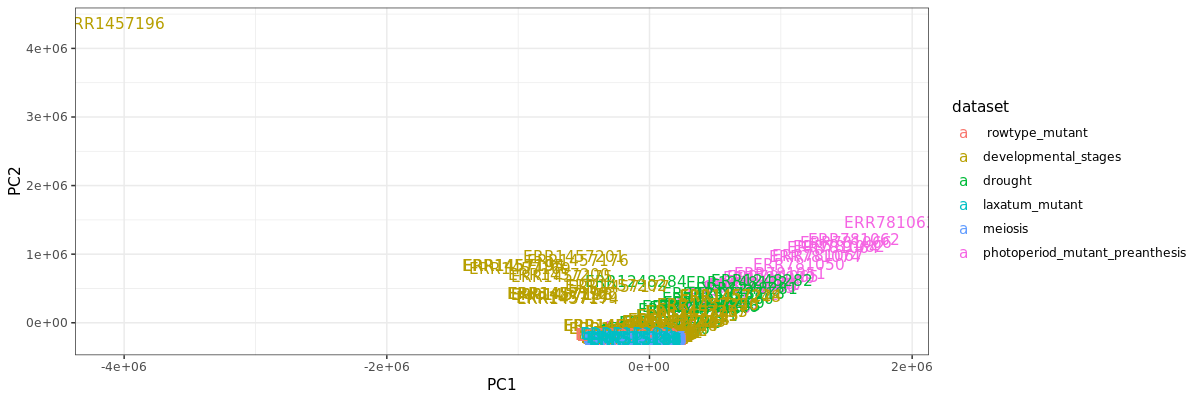

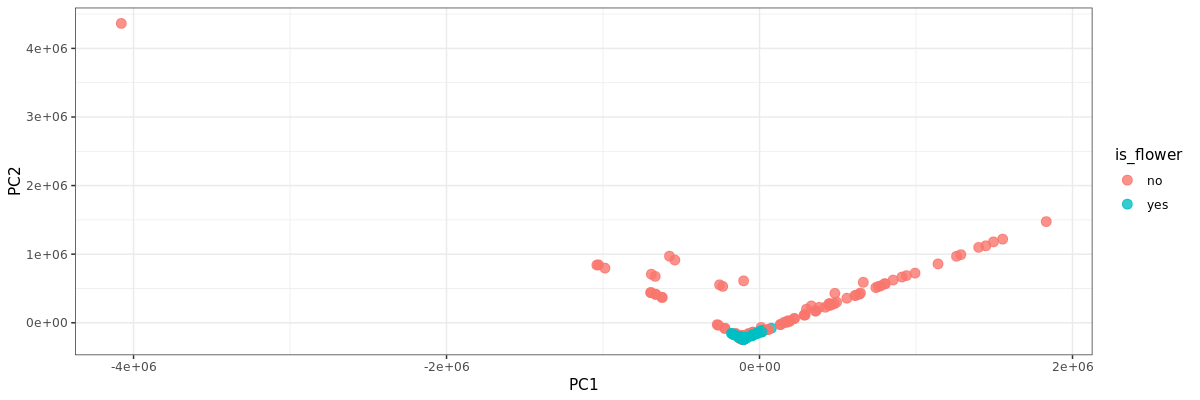

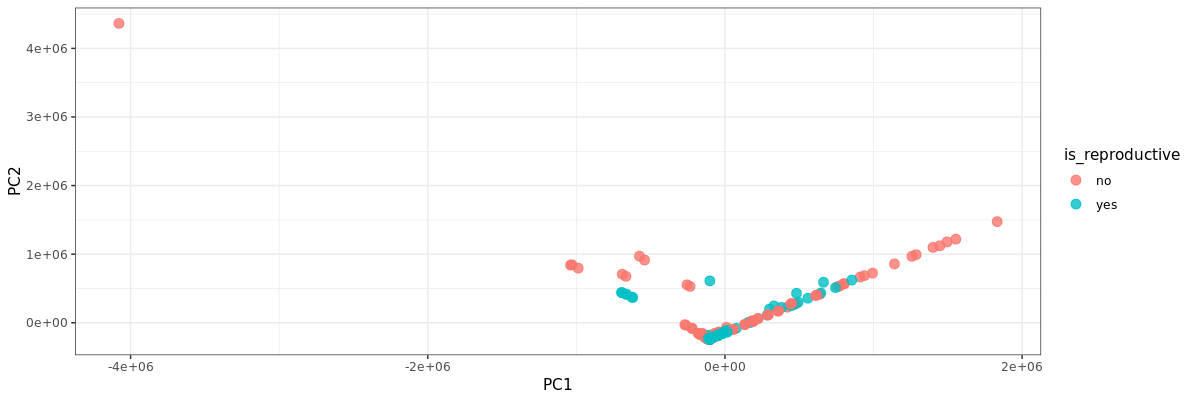

In [50]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_flower1, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_flower1, color_by = 'is_flower',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_flower1, color_by = 'is_reproductive',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

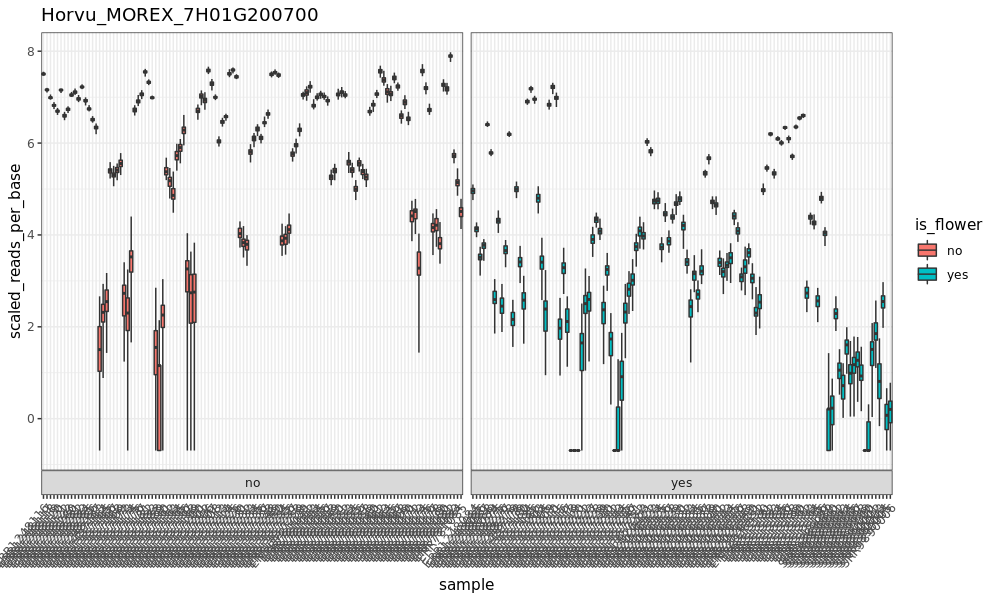

In [88]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
plot_bootstrap(so_flower1, 'Horvu_MOREX_7H01G200700', color_by = 'is_flower',units='scaled_reads_per_base')

In [52]:
# create models
so_flower1 <- sleuth_fit(so_flower1, ~dataset + is_flower + is_reproductive, 'full')
so_flower1 <- sleuth_fit(so_flower1, ~dataset + is_flower, 'reduced')

fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_1H01G070600, Horvu_MOREX_5H01G674500
computing variance of betas
fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_1H01G070600, Horvu_MOREX_5H01G674500
computing variance of betas


In [53]:
# perform DGE test
so_flower1 <- sleuth_lrt(so_flower1, 'reduced', 'full')

In [54]:
models(so_flower1)

[  full  ]
formula:  ~dataset + is_flower + is_reproductive 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis
 	is_floweryes
 	is_reproductiveyes
[  reduced  ]
formula:  ~dataset + is_flower 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis
 	is_floweryes


In [62]:
table_flower1 <- sleuth_results(so_flower1, 'reduced:full', 'lrt', show_all = FALSE)
sig_flower1_1 <- filter(table_flower1, qval <= 0.1)
glimpse(sig_flower1_1)
sig_flower1_05 <- filter(table_flower1, qval <= 0.05)
glimpse(sig_flower1_05)
sig_flower1_01 <- filter(table_flower1, qval <= 0.01)
glimpse(sig_flower1_01)
# look at table and few of 0.05
head(sig_flower1_05, 5)

Rows: 10,438
Columns: 12
$ target_id       <chr> "Horvu_MOREX_7H01G200700", "Horvu_MOREX_4H01G454700",…
$ pval            <dbl> 3.399825e-26, 3.744609e-25, 2.891981e-25, 1.307299e-2…
$ qval            <dbl> 6.856767e-22, 2.517376e-21, 2.517376e-21, 6.591403e-1…
$ test_stat       <dbl> 112.09856, 107.34279, 107.85487, 91.18679, 87.92538, …
$ rss             <dbl> 538.3597, 638.3433, 444.2588, 503.3117, 468.0568, 467…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 4.723927, 4.827195, 4.788425, 2.496434, 3.668173, 2.2…
$ var_obs         <dbl> 4.7498619, 4.8076010, 4.6101010, 3.3501858, 5.0406419…
$ tech_var        <dbl> 0.05990698, 0.04977041, 0.05870737, 0.21000586, 0.060…
$ sigma_sq        <dbl> 2.2910089, 2.7377548, 1.8812875, 1.9878617, 1.9836326…
$ smooth_sigma_sq <dbl> 0.4045290, 0.3768608, 0.3869779, 1.1976406, 0.7989371…
$ final_sigma_sq  <dbl> 2.2910089, 2.7377548, 1.8812875, 1.9878617, 1.9836326…
Rows: 5,846
Columns: 12
$ t

target_id               pval         qval         test_stat rss     
1 Horvu_MOREX_7H01G200700 3.399825e-26 6.856767e-22 112.09856 538.3597
2 Horvu_MOREX_4H01G454700 3.744609e-25 2.517376e-21 107.34279 638.3433
3 Horvu_MOREX_5H01G494900 2.891981e-25 2.517376e-21 107.85487 444.2588
4 Horvu_MOREX_1H01G584000 1.307299e-21 6.591403e-18  91.18679 503.3117
5 Horvu_MOREX_3H01G035800 6.797088e-21 2.741674e-17  87.92538 468.0568
  degrees_free mean_obs var_obs  tech_var   sigma_sq smooth_sigma_sq
1 1            4.723927 4.749862 0.05990698 2.291009 0.4045290      
2 1            4.827195 4.807601 0.04977041 2.737755 0.3768608      
3 1            4.788425 4.610101 0.05870737 1.881287 0.3869779      
4 1            2.496434 3.350186 0.21000586 1.987862 1.1976406      
5 1            3.668173 5.040642 0.06028372 1.983633 0.7989371      
  final_sigma_sq
1 2.291009      
2 2.737755      
3 1.881287      
4 1.987862      
5 1.983633

In [63]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig_flower1_1, file = "deg_flower1_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_flower1_05, file = "deg_flower1_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_flower1_01, file = "deg_flower1_signif0_01.csv", sep = ",", col.names = TRUE)

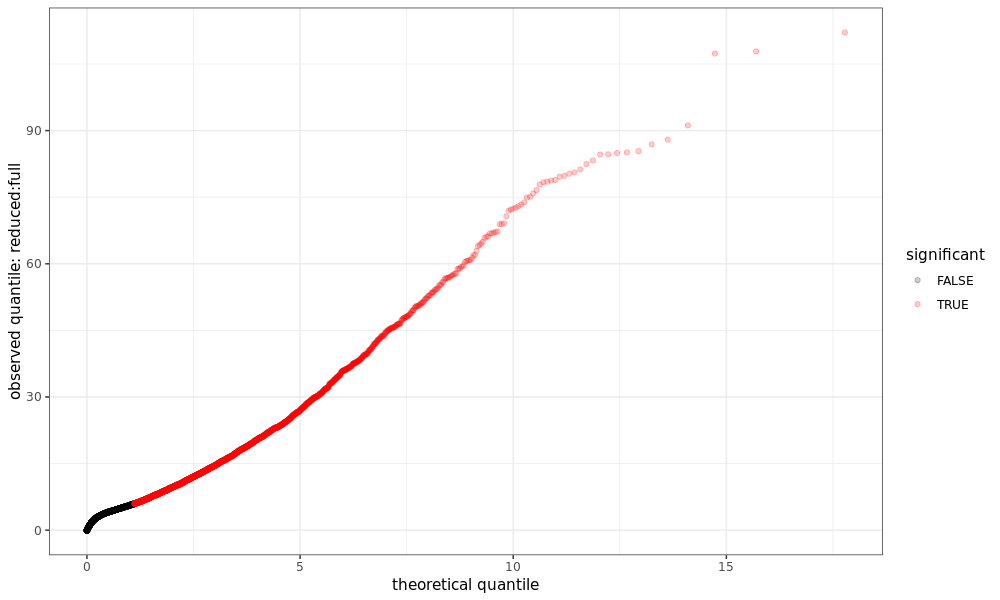

In [56]:
plot_qq(so_flower1, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

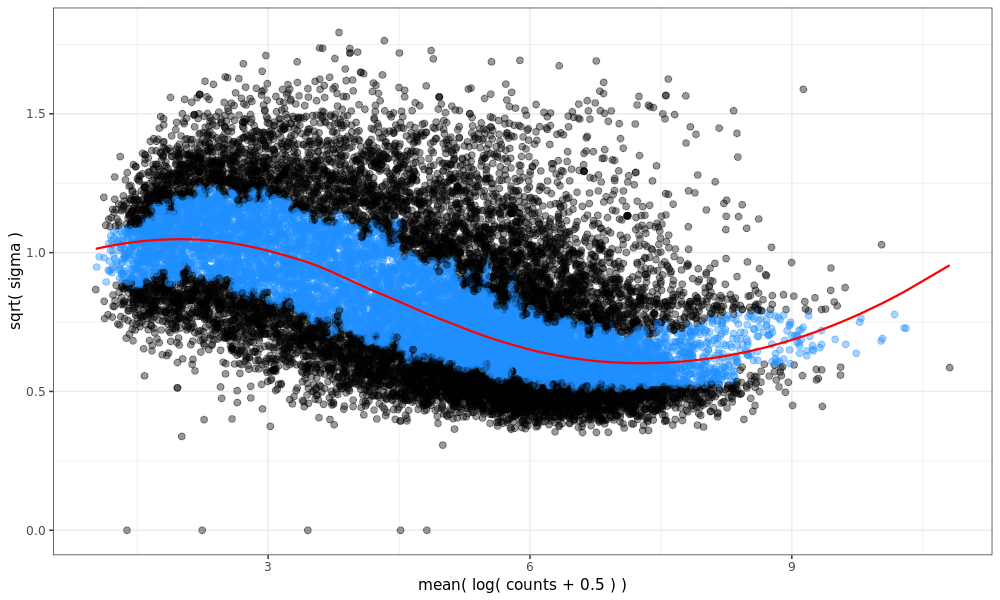

In [57]:
plot_mean_var(so_flower1,which_model="full")

# 2. Flower contrast: **all vs flower without dev.stages**
 * bc dev.stages assignment is still an arbitrary choice!
     - `null = dataset`
     - `full = dataset+is_flower[yes-no]`

## 2.1 Contrast variables
* **is_flower:** yes = inflorescence, no = all other tissue kinds

In [115]:
barley_flower2 <- barley_meta %>% mutate(is_flower = str_detect(high_level_tissue, "inflorescence")) %>%
                     mutate(is_flower = str_replace(is_flower, "TRUE", "yes")) %>%
                     mutate(is_flower = str_replace(is_flower, "FALSE", "no")) %>%
                    select(ID, dataset, is_flower)
barley_flower2$ID <- as.factor(barley_flower2$ID)
barley_flower2$dataset <- as.factor(barley_flower2$dataset)
barley_flower2$is_flower <- as.factor(barley_flower2$is_flower)
glimpse(barley_flower2)
tail(barley_flower2, 3)

Rows: 236
Columns: 3
$ ID        <fct> ERR781039, ERR781041, ERR781042, ERR781043, ERR781044, ERR7…
$ dataset   <fct> photoperiod_mutant_preanthesis, photoperiod_mutant_preanthe…
$ is_flower <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, no, no,…


ID        dataset        is_flower
234 ERR515195 laxatum_mutant yes      
235 ERR515196 laxatum_mutant yes      
236 ERR515197 laxatum_mutant yes

## 2.2 Filtering NA values
(not crucial!)

In [46]:
#m_filt <- m %>% filter(gene != "Horvu_MOREX_2H01G239500")
#m_filt <- m_filt %>% filter(gene != "Horvu_MOREX_4H01G531500")
#dim(m_filt)

[1] 49279     2

In [67]:
s2c_flower2 <- mutate(barley_flower2, path = files, sample = ID)
head(s2c_flower2, 3)

ID        dataset                        is_flower
1 ERR781039 photoperiod_mutant_preanthesis no       
2 ERR781041 photoperiod_mutant_preanthesis no       
3 ERR781042 photoperiod_mutant_preanthesis no       
  path                                                     sample   
1 ../04_Kallisto_allreads_symlinked/ERR781039/abundance.h5 ERR781039
2 ../04_Kallisto_allreads_symlinked/ERR781041/abundance.h5 ERR781041
3 ../04_Kallisto_allreads_symlinked/ERR781042/abundance.h5 ERR781042

In [70]:
# construct the sleuth-object
so_flower2 <- sleuth_prep(sample_to_covariates = s2c_flower2, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
............................................................................................................................................................................................................................................
normalizing est_counts
20169 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
20169 genes passed the filter
summarizing bootstraps
.................................................
..................................................
..................................................
..................................................
.....................................


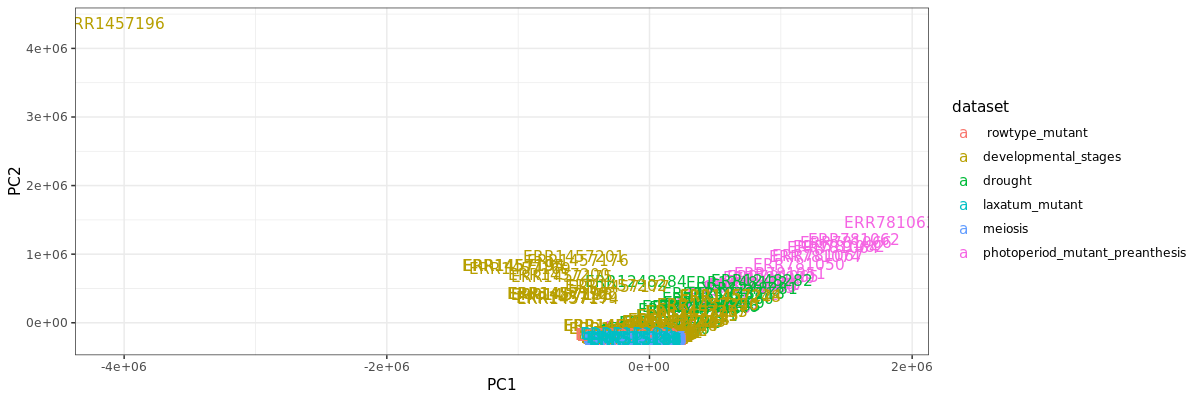

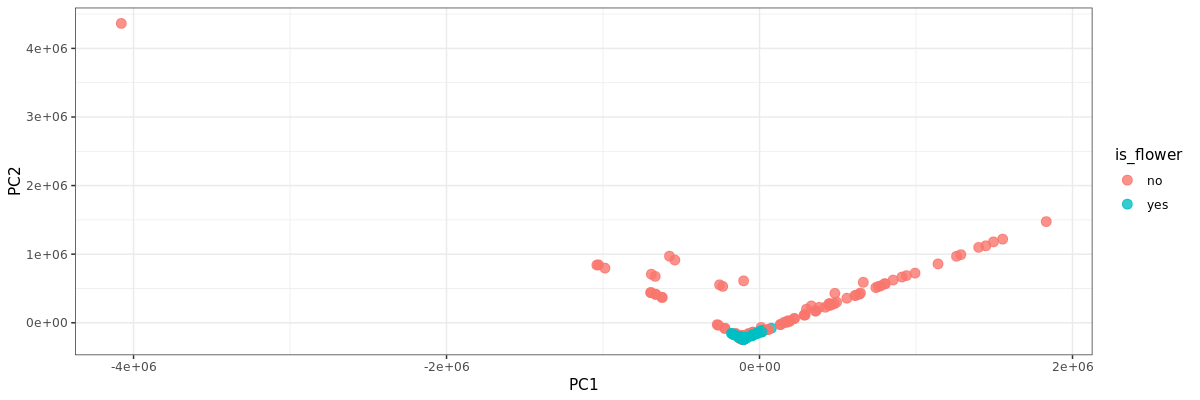

In [72]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_flower2, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_flower2, color_by = 'is_flower',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

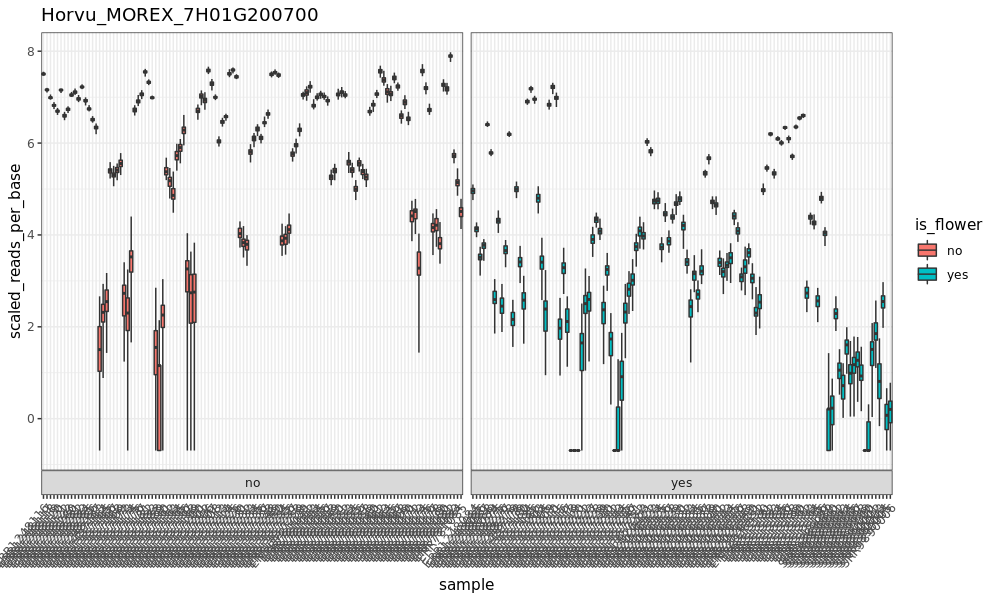

In [73]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
plot_bootstrap(so_flower2, 'Horvu_MOREX_7H01G200700', color_by = 'is_flower',units='scaled_reads_per_base')

In [74]:
# create models
so_flower2 <- sleuth_fit(so_flower1, ~dataset + is_flower, 'full')
so_flower2 <- sleuth_fit(so_flower1, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_1H01G070600, Horvu_MOREX_5H01G674500
computing variance of betas
fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_1H01G070600, Horvu_MOREX_5H01G674500
computing variance of betas


In [75]:
# perform DGE test
so_flower2 <- sleuth_lrt(so_flower2, 'reduced', 'full')

In [76]:
models(so_flower2)

[  full  ]
formula:  ~dataset + is_flower + is_reproductive 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis
 	is_floweryes
 	is_reproductiveyes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis


In [77]:
table_flower2 <- sleuth_results(so_flower2, 'reduced:full', 'lrt', show_all = FALSE)
sig_flower2_1 <- filter(table_flower2, qval <= 0.1)
glimpse(sig_flower2_1)
sig_flower2_05 <- filter(table_flower2, qval <= 0.05)
glimpse(sig_flower2_05)
sig_flower2_01 <- filter(table_flower2, qval <= 0.01)
glimpse(sig_flower2_01)
# look at table and few of 0.05
head(sig_flower2_05, 5)

Rows: 18,940
Columns: 12
$ target_id       <chr> "Horvu_MOREX_3H01G717600", "Horvu_MOREX_2H01G626900",…
$ pval            <dbl> 1.007908e-55, 9.971808e-54, 2.459715e-52, 2.722948e-5…
$ qval            <dbl> 2.032748e-51, 1.005557e-49, 1.653584e-48, 1.372910e-4…
$ test_stat       <dbl> 253.2686, 244.0797, 237.6688, 232.8602, 231.6624, 223…
$ rss             <dbl> 984.69912, 239.60246, 992.34905, 1206.02292, 162.5645…
$ degrees_free    <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,…
$ mean_obs        <dbl> 2.840605, 6.200921, 5.232395, 4.156715, 5.502467, 4.1…
$ var_obs         <dbl> 7.0672113, 1.7540082, 8.2758432, 7.7020870, 0.9349899…
$ tech_var        <dbl> 0.121526414, 0.015581662, 0.107704206, 0.120205701, 0…
$ sigma_sq        <dbl> 4.1597741, 1.0261682, 4.2068569, 5.1233722, 0.6852838…
$ smooth_sigma_sq <dbl> 1.2462768, 0.1851629, 0.3207955, 0.6545367, 0.2677030…
$ final_sigma_sq  <dbl> 4.1597741, 1.0261682, 4.2068569, 5.1233722, 0.6852838…
Rows: 18,552
Columns: 12
$ 

target_id               pval         qval         test_stat rss      
1 Horvu_MOREX_3H01G717600 1.007908e-55 2.032748e-51 253.2686   984.6991
2 Horvu_MOREX_2H01G626900 9.971808e-54 1.005557e-49 244.0797   239.6025
3 Horvu_MOREX_7H01G298400 2.459715e-52 1.653584e-48 237.6688   992.3491
4 Horvu_MOREX_7H01G536500 2.722948e-51 1.372910e-47 232.8602  1206.0229
5 Horvu_MOREX_7H01G303100 4.956295e-51 1.999171e-47 231.6624   162.5646
  degrees_free mean_obs var_obs   tech_var   sigma_sq  smooth_sigma_sq
1 2            2.840605 7.0672113 0.12152641 4.1597741 1.2462768      
2 2            6.200921 1.7540082 0.01558166 1.0261682 0.1851629      
3 2            5.232395 8.2758432 0.10770421 4.2068569 0.3207955      
4 2            4.156715 7.7020870 0.12020570 5.1233722 0.6545367      
5 2            5.502467 0.9349899 0.02151874 0.6852838 0.2677030      
  final_sigma_sq
1 4.1597741     
2 1.0261682     
3 4.2068569     
4 5.1233722     
5 0.6852838

In [78]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig_flower2_1, file = "deg_flower2_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_flower2_05, file = "deg_flower2_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_flower2_01, file = "deg_flower2_signif0_01.csv", sep = ",", col.names = TRUE)

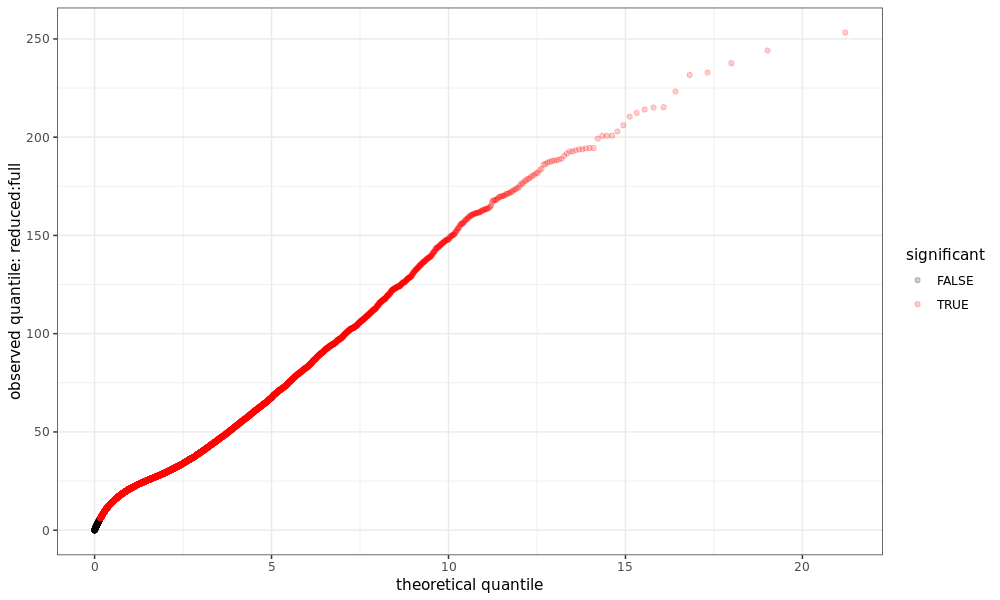

In [79]:
plot_qq(so_flower2, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

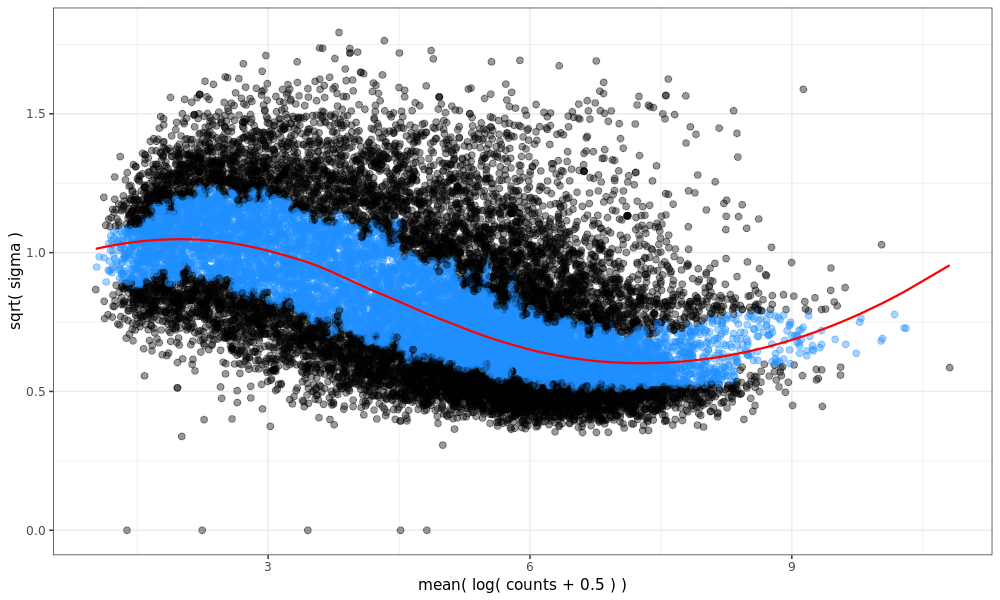

In [57]:
plot_mean_var(so_flower2,which_model="full")

# 3. Flower contrast: **all vs flower with Zadocs as time course series factor**
## 3.1 Create contrast variables
 * modells:
     - `null = dataset + Zadoc-scale`
     - `full = dataset + Zadoc-scale + is_flower[yes-no]`

In [120]:
barley_flower3 <- barley_meta %>% mutate(is_flower = str_detect(high_level_tissue, "inflorescence")) %>%
                     mutate(is_flower = str_replace(is_flower, "TRUE", "yes")) %>%
                     mutate(is_flower = str_replace(is_flower, "FALSE", "no")) %>%
                    select(ID, dataset, zadoc_scale, is_flower)
barley_flower3$ID <- as.factor(barley_flower3$ID)
barley_flower3$dataset <- as.factor(barley_flower3$dataset)
barley_flower3$is_flower <- as.factor(barley_flower3$is_flower)
barley_flower3$zadoc_scale <- as.factor(barley_flower3$zadoc_scale)
glimpse(barley_flower3)
tail(barley_flower3, 3)

Rows: 236
Columns: 4
$ ID          <fct> ERR781039, ERR781041, ERR781042, ERR781043, ERR781044, ER…
$ dataset     <fct> photoperiod_mutant_preanthesis, photoperiod_mutant_preant…
$ zadoc_scale <fct> 9, 9, 11, 11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14,…
$ is_flower   <fct> no, no, no, no, no, no, no, no, no, no, no, no, no, no, n…


ID        dataset        zadoc_scale is_flower
234 ERR515195 laxatum_mutant 31          yes      
235 ERR515196 laxatum_mutant 31          yes      
236 ERR515197 laxatum_mutant 31          yes

In [125]:
s2c_flower3 <- mutate(barley_flower3, path = files, sample = ID)
head(s2c_flower3, 3)

ID        dataset                        zadoc_scale is_flower
1 ERR781039 photoperiod_mutant_preanthesis 9           no       
2 ERR781041 photoperiod_mutant_preanthesis 9           no       
3 ERR781042 photoperiod_mutant_preanthesis 11          no       
  path                                                     sample   
1 ../04_Kallisto_allreads_symlinked/ERR781039/abundance.h5 ERR781039
2 ../04_Kallisto_allreads_symlinked/ERR781041/abundance.h5 ERR781041
3 ../04_Kallisto_allreads_symlinked/ERR781042/abundance.h5 ERR781042

In [126]:
# construct the sleuth-object
so_flower3 <- sleuth_prep(sample_to_covariates = s2c_flower3, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
............................................................................................................................................................................................................................................
normalizing est_counts
20169 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
20169 genes passed the filter
summarizing bootstraps
.................................................
..................................................
..................................................
..................................................
.....................................


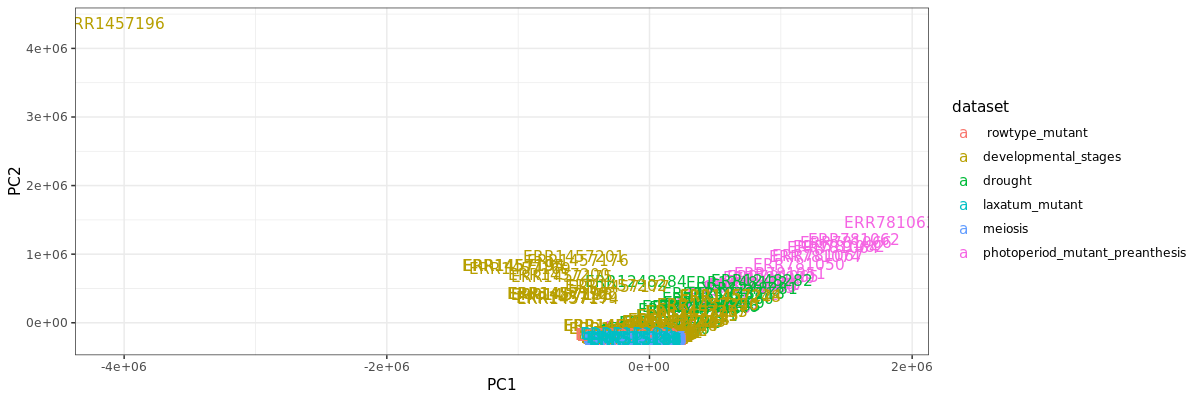

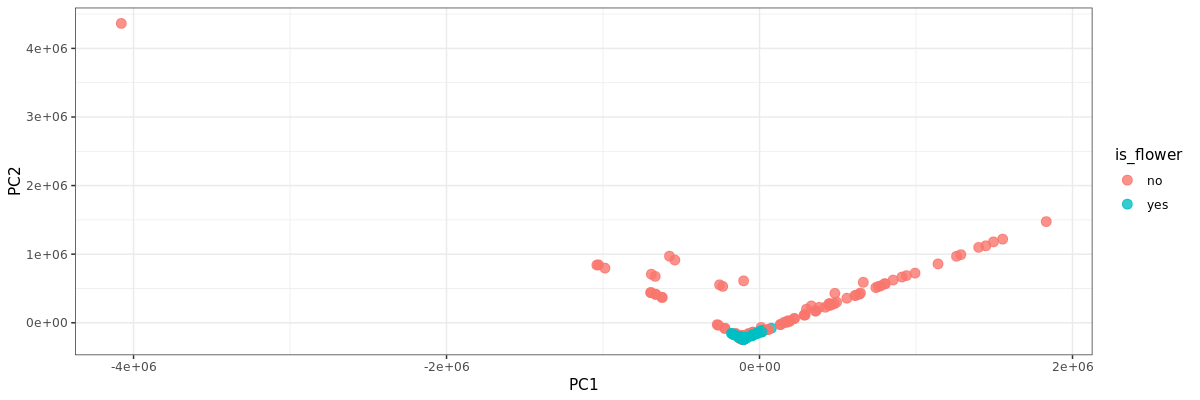

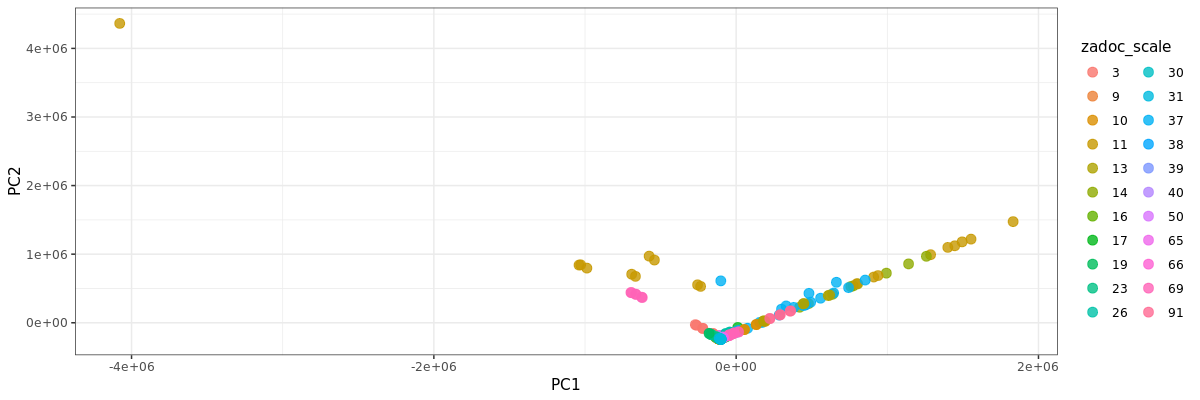

In [127]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_flower3, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_flower3, color_by = 'is_flower',text_labels = FALSE,units='scaled_reads_per_base')
plot_pca(so_flower3, color_by = 'zadoc_scale',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

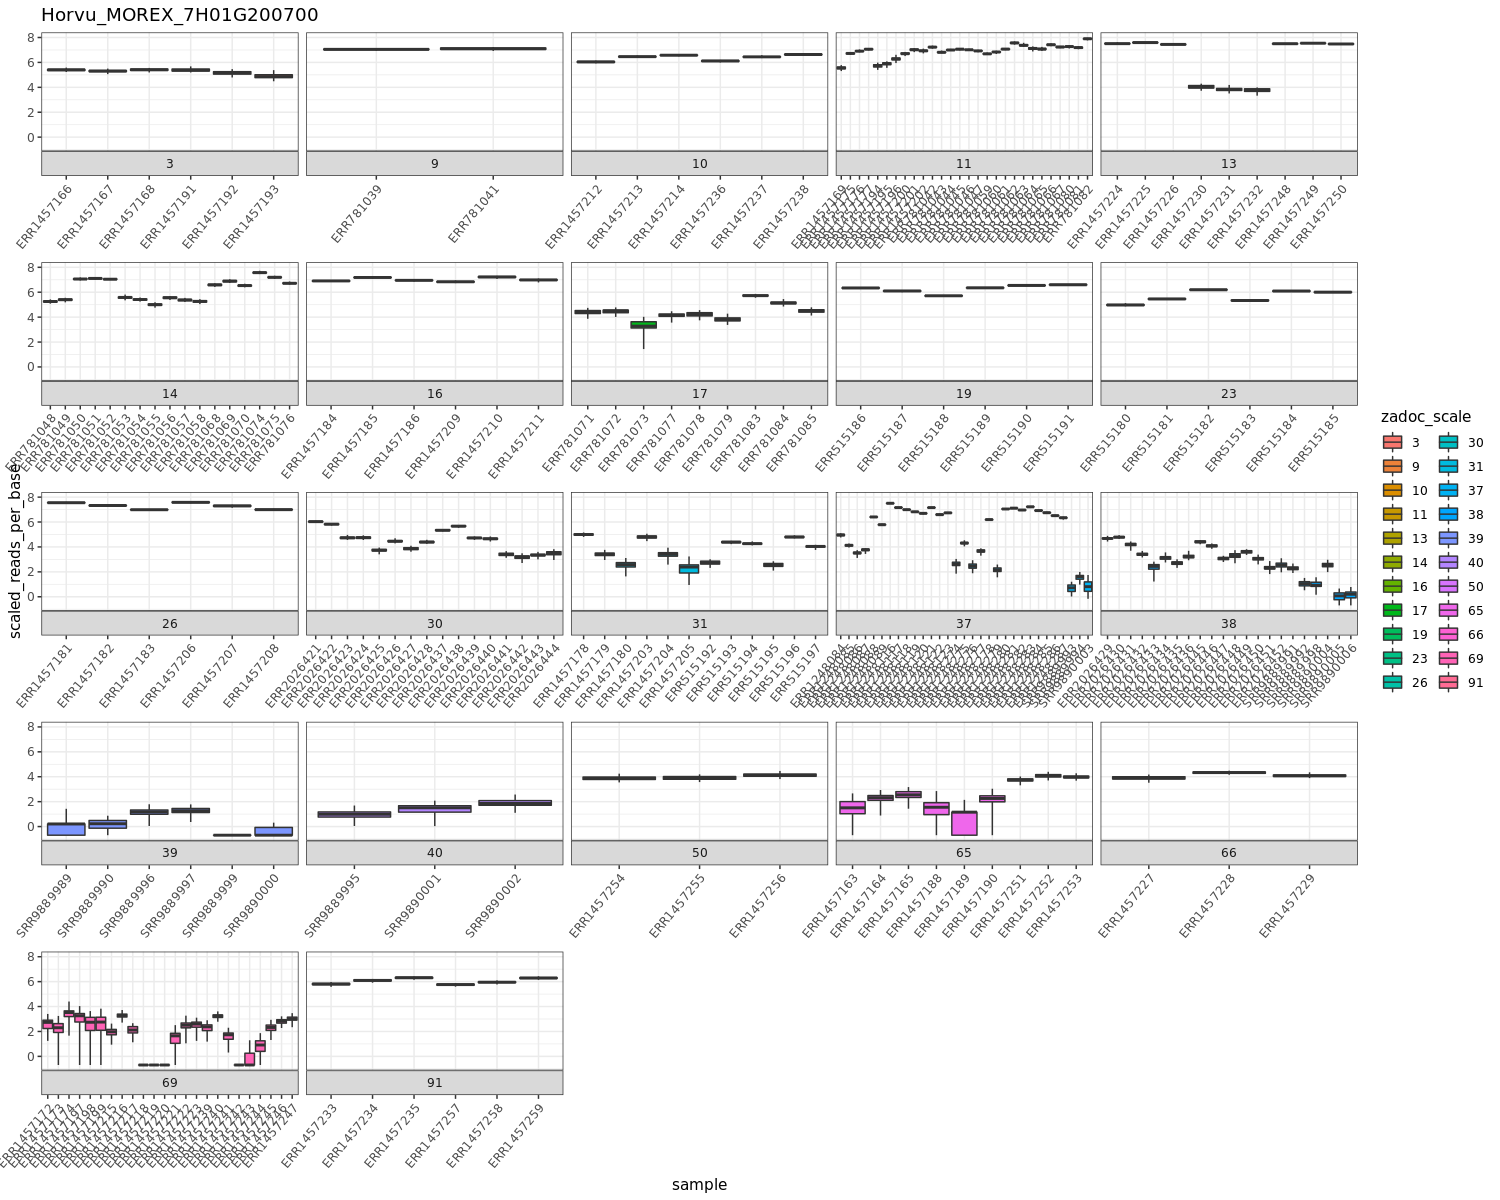

In [132]:
# check for bootstrapping
options(repr.plot.width = 15, repr.plot.height = 12, repr.plot.res = 100)
plot_bootstrap(so_flower3, 'Horvu_MOREX_7H01G200700', color_by = 'zadoc_scale',units='scaled_reads_per_base')

In [166]:
# create models
so_flower3 <- sleuth_fit(so_flower3, ~zadoc_scale + is_flower, 'full')
so_flower3 <- sleuth_fit(so_flower3, ~zadoc_scale, 'reduced')
# singular composition caused by dataset + zadoc_scale -> so I tried excluding dataset, it works in barley
# problem is caused by the fact that some datasets contain only 1-2 kinds of Zadoc-category

fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_1H01G070600
computing variance of betas
fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_1H01G070600, Horvu_MOREX_5H01G674500
computing variance of betas


In [167]:
# perform DGE test
so_flower3 <- sleuth_lrt(so_flower3, 'reduced', 'full')

In [168]:
models(so_flower3)

[  full  ]
formula:  ~zadoc_scale + is_flower 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	zadoc_scale9
 	zadoc_scale10
 	zadoc_scale11
 	zadoc_scale13
 	zadoc_scale14
 	zadoc_scale16
 	zadoc_scale17
 	zadoc_scale19
 	zadoc_scale23
 	zadoc_scale26
 	zadoc_scale30
 	zadoc_scale31
 	zadoc_scale37
 	zadoc_scale38
 	zadoc_scale39
 	zadoc_scale40
 	zadoc_scale50
 	zadoc_scale65
 	zadoc_scale66
 	zadoc_scale69
 	zadoc_scale91
 	is_floweryes
[  reduced  ]
formula:  ~zadoc_scale 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	zadoc_scale9
 	zadoc_scale10
 	zadoc_scale11
 	zadoc_scale13
 	zadoc_scale14
 	zadoc_scale16
 	zadoc_scale17
 	zadoc_scale19
 	zadoc_scale23
 	zadoc_scale26
 	zadoc_scale30
 	zadoc_scale31
 	zadoc_scale37
 	zadoc_scale38
 	zadoc_scale39
 	zadoc_scale40
 	zadoc_scale50
 	zadoc_scale65
 	zadoc_scale66
 	zadoc_scale69
 	zadoc_scale91


In [169]:
table_flower3 <- sleuth_results(so_flower3, 'reduced:full', 'lrt', show_all = FALSE)
sig_flower3_1 <- filter(table_flower3, qval <= 0.1)
glimpse(sig_flower3_1)
sig_flower3_05 <- filter(table_flower3, qval <= 0.05)
glimpse(sig_flower3_05)
sig_flower3_01 <- filter(table_flower3, qval <= 0.01)
glimpse(sig_flower3_01)
# look at table and few of 0.05
head(sig_flower3_05, 5)

Rows: 17,781
Columns: 12
$ target_id       <chr> "Horvu_MOREX_1H01G601500", "Horvu_MOREX_7H01G588200",…
$ pval            <dbl> 2.440685e-58, 2.780950e-55, 8.641669e-55, 2.142571e-5…
$ qval            <dbl> 4.922617e-54, 2.804449e-51, 5.809794e-51, 1.080338e-5…
$ test_stat       <dbl> 259.2981, 245.2767, 243.0183, 241.2097, 239.1295, 236…
$ rss             <dbl> 302.91305, 532.07374, 232.86558, 95.31365, 116.47332,…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 5.127402, 5.339939, 5.574121, 6.045049, 5.502467, 5.6…
$ var_obs         <dbl> 2.8893477, 4.0071764, 1.7352852, 0.9849876, 0.9349899…
$ tech_var        <dbl> 0.053947180, 0.045687506, 0.010413130, 0.008886942, 0…
$ sigma_sq        <dbl> 1.3615344, 2.4406384, 1.0777438, 0.4365039, 0.5227491…
$ smooth_sigma_sq <dbl> 0.2481953, 0.2136975, 0.1827586, 0.1405801, 0.1912951…
$ final_sigma_sq  <dbl> 1.3615344, 2.4406384, 1.0777438, 0.4365039, 0.5227491…
Rows: 17,266
Columns: 12
$ 

target_id               pval         qval         test_stat rss      
1 Horvu_MOREX_1H01G601500 2.440685e-58 4.922617e-54 259.2981  302.91305
2 Horvu_MOREX_7H01G588200 2.780950e-55 2.804449e-51 245.2767  532.07374
3 Horvu_MOREX_1H01G167600 8.641669e-55 5.809794e-51 243.0183  232.86558
4 Horvu_MOREX_1H01G412600 2.142571e-54 1.080338e-50 241.2097   95.31365
5 Horvu_MOREX_7H01G303100 6.088611e-54 2.456024e-50 239.1295  116.47332
  degrees_free mean_obs var_obs   tech_var    sigma_sq  smooth_sigma_sq
1 1            5.127402 2.8893477 0.053947180 1.3615344 0.2481953      
2 1            5.339939 4.0071764 0.045687506 2.4406384 0.2136975      
3 1            5.574121 1.7352852 0.010413130 1.0777438 0.1827586      
4 1            6.045049 0.9849876 0.008886942 0.4365039 0.1405801      
5 1            5.502467 0.9349899 0.021518736 0.5227491 0.1912951      
  final_sigma_sq
1 1.3615344     
2 2.4406384     
3 1.0777438     
4 0.4365039     
5 0.5227491

In [171]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig_flower3_1, file = "deg_flower3_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_flower3_05, file = "deg_flower3_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_flower3_01, file = "deg_flower3_signif0_01.csv", sep = ",", col.names = TRUE)

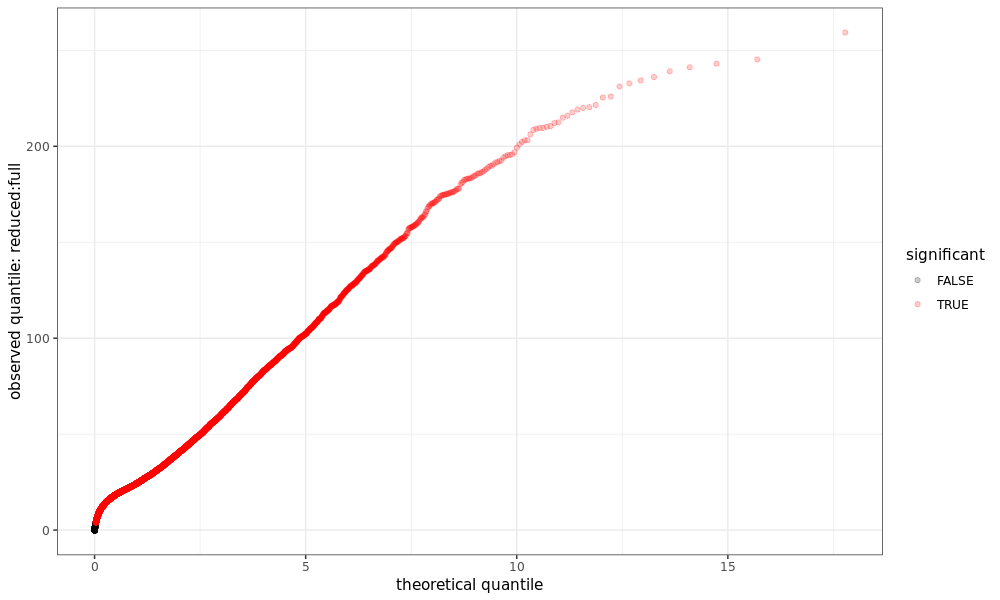

In [170]:
plot_qq(so_flower3, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

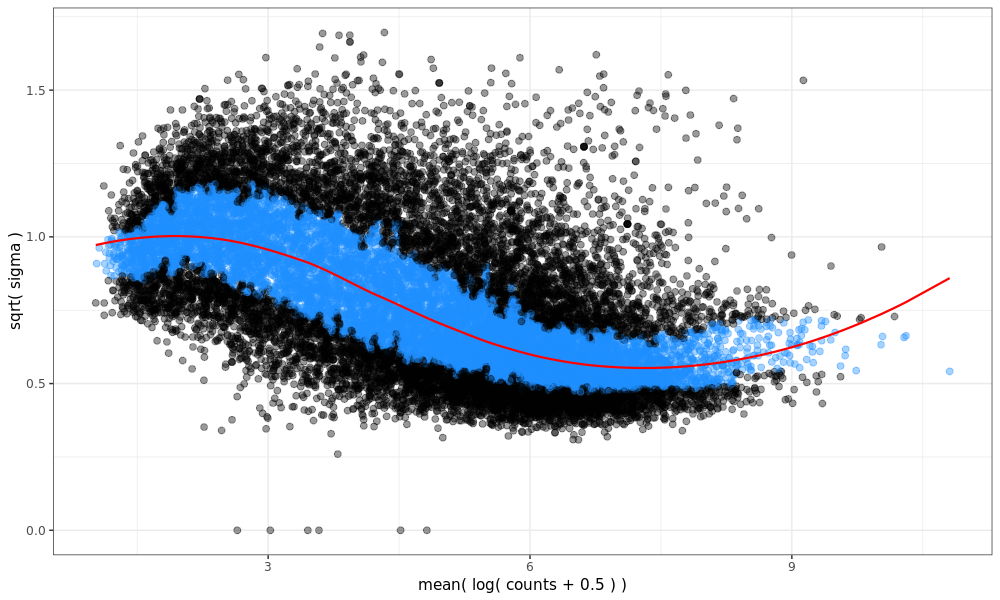

In [172]:
plot_mean_var(so_flower3,which_model="full")

# 4. Flower contrast: **primordiums vs matured flower tissues based on dev.stages**
## 4.1 Create contrast variables
 * **is_primordium:** yes = 13-30Z flower&primordium tissues, no = 31-69Z flower&primordium tissues
 * modells:
     - `null = dataset`
     - `full = dataset+is_primordium[yes-no]`

In [135]:
# here we exclude grain, seedling and root samples from the analysis (this will be repeated with including only inflorescence)
is_primordium_tissue <- barley_meta %>% filter(as.character(high_level_tissue) == "inflorescence" | 
                                               as.character(high_level_tissue) == "leaf" | 
                                               as.character(high_level_tissue) == "meristem" | 
                                               as.character(high_level_tissue) == "stem") %>% select(ID, dataset, zadoc_scale) 
# here we select samples that are in primordium stage
is_primordium_yes <- is_primordium_tissue %>% filter(zadoc_scale <= 30 & zadoc_scale >= 13) %>% 
                                              add_column(is_primordium = "yes") %>% 
                                              select(ID, dataset, is_primordium)
# here we select samples that are not in primordium stage, but are in flowering stage
is_primordium_no <- is_primordium_tissue %>% filter(zadoc_scale >= 31 & zadoc_scale <= 69) %>% 
                                             add_column(is_primordium = "no") %>% 
                                             select(ID, dataset, is_primordium)
# here we join tables of primordium stage or not into one
barley_flower4 <- bind_rows(is_primordium_yes, is_primordium_no)
barley_flower4$ID <- as.factor(barley_flower4$ID)
barley_flower4$dataset <- as.factor(barley_flower4$dataset)
barley_flower4$is_primordium <- as.factor(barley_flower4$is_primordium)
glimpse(is_primordium_tissue)
glimpse(is_primordium_yes)
glimpse(is_primordium_no)
glimpse(barley_flower4)
tail(barley_flower4, 3)

Rows: 202
Columns: 3
$ ID          <chr> "ERR781039", "ERR781041", "ERR781042", "ERR781043", "ERR7…
$ dataset     <chr> "photoperiod_mutant_preanthesis", "photoperiod_mutant_pre…
$ zadoc_scale <int> 9, 9, 11, 11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14,…
Rows: 72
Columns: 3
$ ID            <chr> "ERR781048", "ERR781049", "ERR781050", "ERR781051", "ER…
$ dataset       <chr> "photoperiod_mutant_preanthesis", "photoperiod_mutant_p…
$ is_primordium <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes",…
Rows: 98
Columns: 3
$ ID            <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR1248087",…
$ dataset       <chr> "drought", "drought", "drought", "drought", "drought", …
$ is_primordium <chr> "no", "no", "no", "no", "no", "no", "no", "no", "no", "…
Rows: 170
Columns: 3
$ ID            <fct> ERR781048, ERR781049, ERR781050, ERR781051, ERR781052, …
$ dataset       <fct> photoperiod_mutant_preanthesis, photoperiod_mutant_prea…
$ is_primordium <fct> yes, yes, yes, yes, yes, ye

ID        dataset        is_primordium
168 ERR515195 laxatum_mutant no           
169 ERR515196 laxatum_mutant no           
170 ERR515197 laxatum_mutant no

In [136]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", barley_flower4$ID, "abundance.h5")
names(files) <- paste0(barley_flower4$ID)
head(files)
all(file.exists(files))

ERR781048 
"../04_Kallisto_allreads_symlinked/ERR781048/abundance.h5" 
                                                 ERR781049 
"../04_Kallisto_allreads_symlinked/ERR781049/abundance.h5" 
                                                 ERR781050 
"../04_Kallisto_allreads_symlinked/ERR781050/abundance.h5" 
                                                 ERR781051 
"../04_Kallisto_allreads_symlinked/ERR781051/abundance.h5" 
                                                 ERR781052 
"../04_Kallisto_allreads_symlinked/ERR781052/abundance.h5" 
                                                 ERR781053 
"../04_Kallisto_allreads_symlinked/ERR781053/abundance.h5"

[1] TRUE

In [137]:
s2c_flower4 <- mutate(barley_flower4, path = files, sample = ID)
head(s2c_flower4, 3)

ID        dataset                        is_primordium
1 ERR781048 photoperiod_mutant_preanthesis yes          
2 ERR781049 photoperiod_mutant_preanthesis yes          
3 ERR781050 photoperiod_mutant_preanthesis yes          
  path                                                     sample   
1 ../04_Kallisto_allreads_symlinked/ERR781048/abundance.h5 ERR781048
2 ../04_Kallisto_allreads_symlinked/ERR781049/abundance.h5 ERR781049
3 ../04_Kallisto_allreads_symlinked/ERR781050/abundance.h5 ERR781050

In [138]:
# construct the sleuth-object
so_flower4 <- sleuth_prep(sample_to_covariates = s2c_flower4, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
..........................................................................................................................................................................
normalizing est_counts
20517 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
20517 genes passed the filter
summarizing bootstraps
.................................................
..................................................
..................................................
.....................


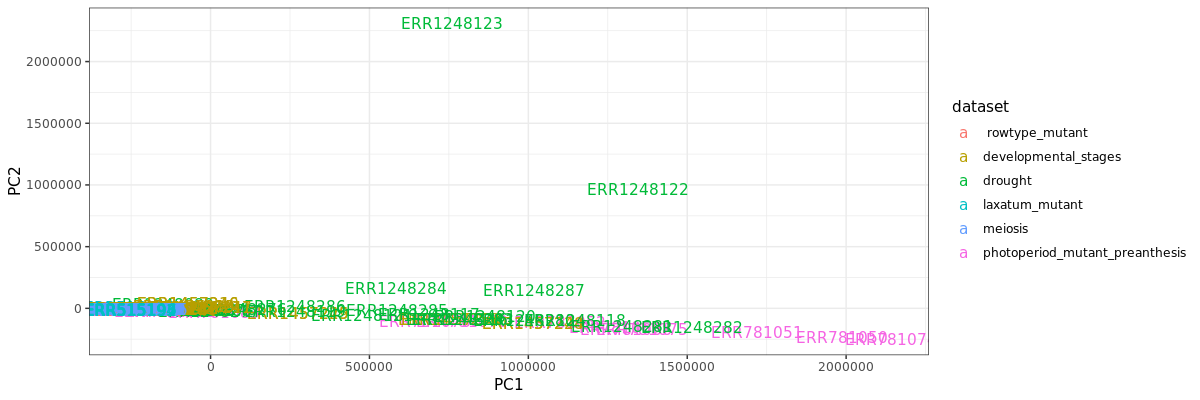

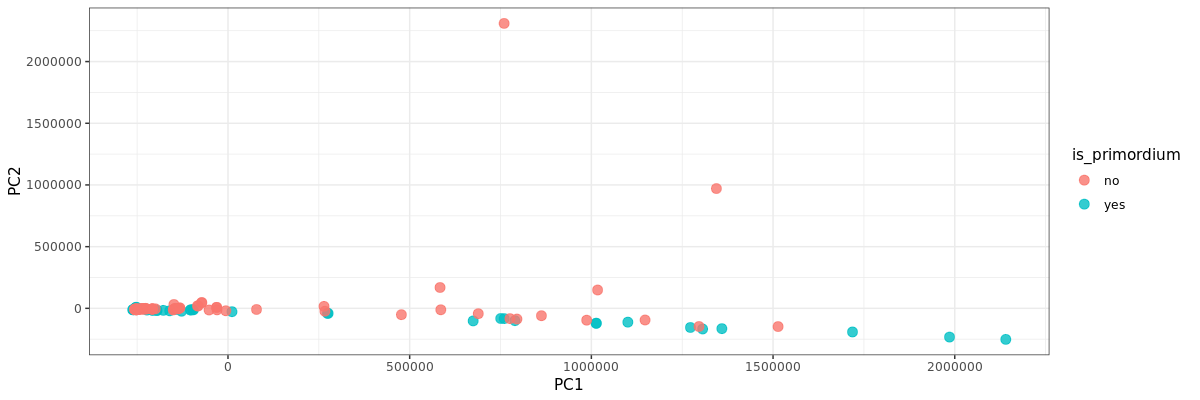

In [139]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_flower4, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_flower4, color_by = 'is_primordium',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

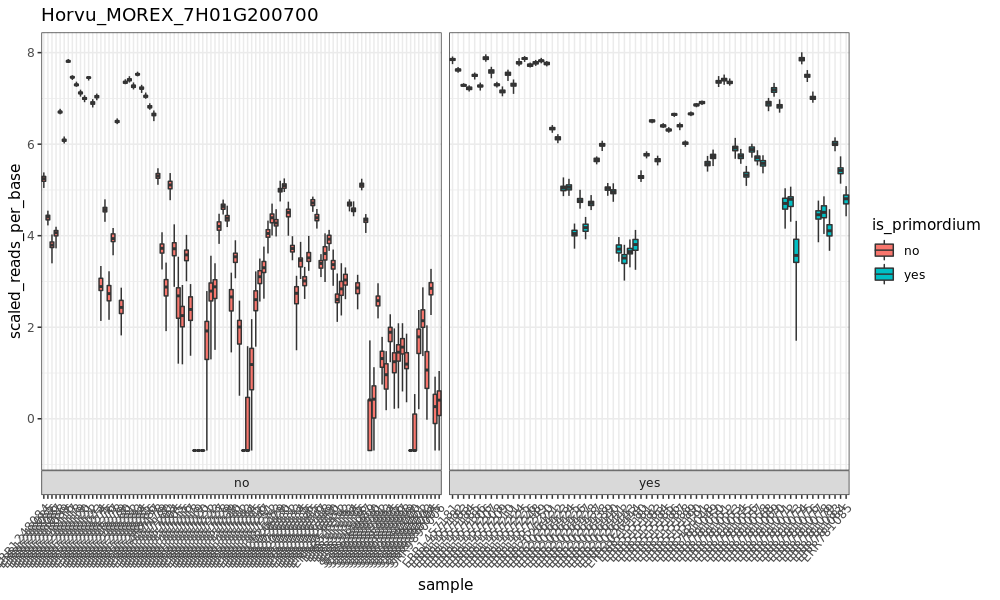

In [140]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
plot_bootstrap(so_flower4, 'Horvu_MOREX_7H01G200700', color_by = 'is_primordium',units='scaled_reads_per_base')

In [141]:
# create models
so_flower4 <- sleuth_fit(so_flower4, ~dataset + is_primordium, 'full')
so_flower4 <- sleuth_fit(so_flower4, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_1H01G597500
computing variance of betas
fitting measurement error models
shrinkage estimation
1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Horvu_MOREX_1H01G597500
computing variance of betas


In [142]:
# perform DGE test
so_flower4 <- sleuth_lrt(so_flower4, 'reduced', 'full')

In [143]:
models(so_flower4)

[  full  ]
formula:  ~dataset + is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis
 	is_primordiumyes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	datasetphotoperiod_mutant_preanthesis


In [144]:
table_flower4 <- sleuth_results(so_flower4, 'reduced:full', 'lrt', show_all = FALSE)
sig_flower4_1 <- filter(table_flower4, qval <= 0.1)
glimpse(sig_flower4_1)
sig_flower4_05 <- filter(table_flower4, qval <= 0.05)
glimpse(sig_flower4_05)
sig_flower4_01 <- filter(table_flower4, qval <= 0.01)
glimpse(sig_flower4_01)
# look at table and few of 0.05
head(sig_flower4_05, 5)

Rows: 12,376
Columns: 12
$ target_id       <chr> "Horvu_MOREX_5H01G494900", "Horvu_MOREX_3H01G465200",…
$ pval            <dbl> 6.232659e-36, 3.963832e-30, 9.023446e-28, 3.903604e-2…
$ qval            <dbl> 1.278755e-31, 4.066297e-26, 6.171135e-24, 2.002256e-2…
$ test_stat       <dbl> 156.60861, 130.06597, 119.29550, 102.69789, 91.18879,…
$ rss             <dbl> 303.37737, 493.40026, 1059.59326, 612.18508, 600.1643…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 5.270462, 4.184469, 3.109927, 4.636460, 2.092305, 4.6…
$ var_obs         <dbl> 5.6862220, 3.9622626, 10.1913997, 4.5689129, 7.472956…
$ tech_var        <dbl> 0.05413286, 0.06668866, 0.05006038, 0.05300676, 0.096…
$ sigma_sq        <dbl> 1.7957291, 2.9418495, 6.4108742, 3.6798291, 3.5633709…
$ smooth_sigma_sq <dbl> 0.2907854, 0.5801062, 0.9599387, 0.4380757, 1.1042131…
$ final_sigma_sq  <dbl> 1.7957291, 2.9418495, 6.4108742, 3.6798291, 3.5633709…
Rows: 7,321
Columns: 12
$ t

target_id               pval         qval         test_stat rss      
1 Horvu_MOREX_5H01G494900 6.232659e-36 1.278755e-31 156.60861  303.3774
2 Horvu_MOREX_3H01G465200 3.963832e-30 4.066297e-26 130.06597  493.4003
3 Horvu_MOREX_4H01G409400 9.023446e-28 6.171135e-24 119.29550 1059.5933
4 Horvu_MOREX_4H01G454700 3.903604e-24 2.002256e-20 102.69789  612.1851
5 Horvu_MOREX_1H01G082000 1.305978e-21 5.358949e-18  91.18879  600.1644
  degrees_free mean_obs var_obs   tech_var   sigma_sq smooth_sigma_sq
1 1            5.270462  5.686222 0.05413286 1.795729 0.2907854      
2 1            4.184469  3.962263 0.06668866 2.941850 0.5801062      
3 1            3.109927 10.191400 0.05006038 6.410874 0.9599387      
4 1            4.636460  4.568913 0.05300676 3.679829 0.4380757      
5 1            2.092305  7.472956 0.09616805 3.563371 1.1042131      
  final_sigma_sq
1 1.795729      
2 2.941850      
3 6.410874      
4 3.679829      
5 3.563371

In [145]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig_flower4_1, file = "deg_flower4_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_flower4_05, file = "deg_flower4_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_flower4_01, file = "deg_flower4_signif0_01.csv", sep = ",", col.names = TRUE)

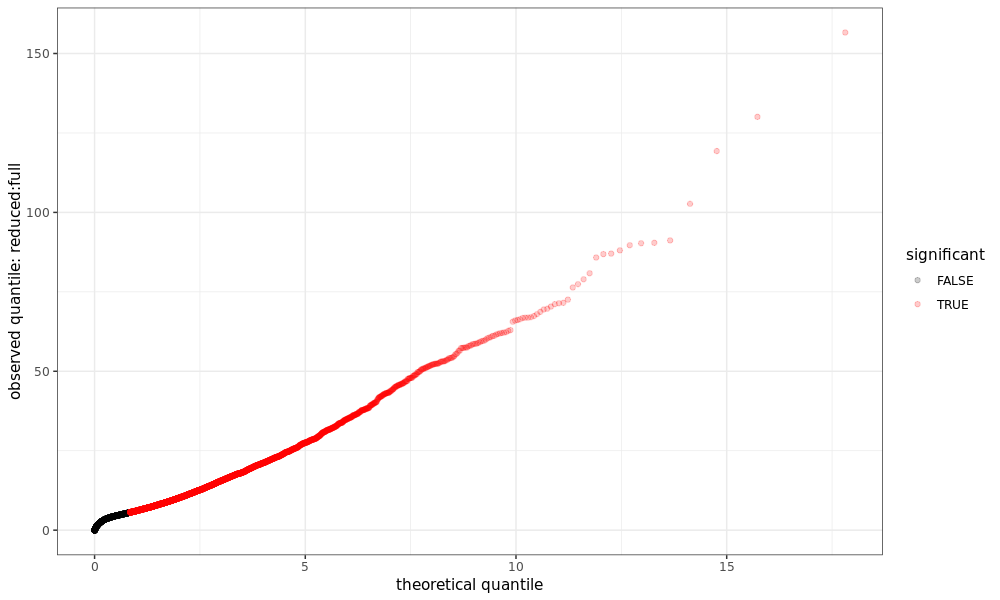

In [146]:
plot_qq(so_flower4, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

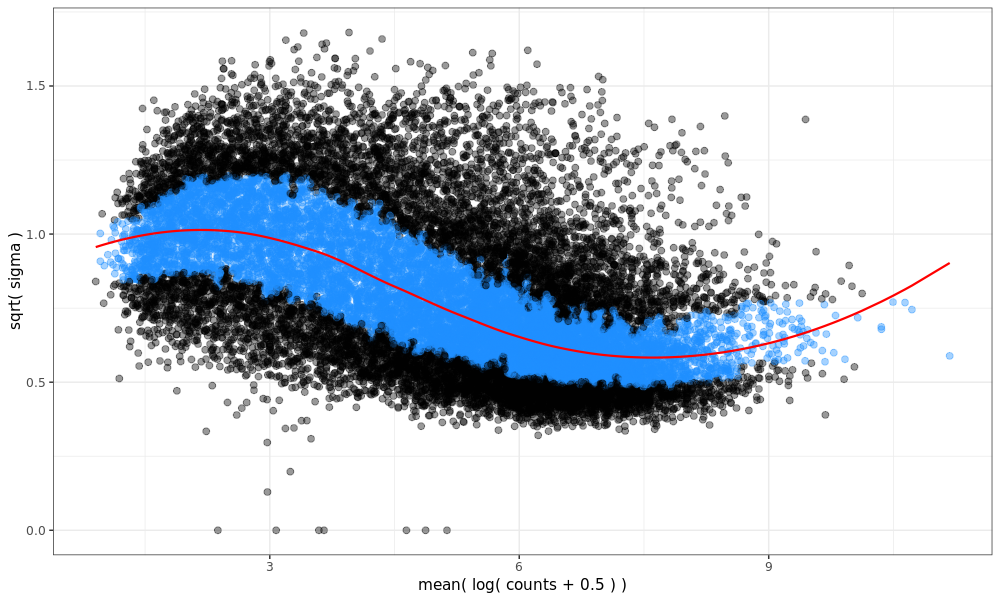

In [147]:
plot_mean_var(so_flower4,which_model="full")

# 5. Flower contrast: **primordiums vs matured flower tissues based on dev.stages**
## 5.1 Create contrast variables
 * **is_primordium:** yes = 13-30Z flower tissues, no = 31-69Z flower tissues
 * modells:
     - `null = dataset`
     - `full = dataset+is_primordium[yes-no]`

In [148]:
# here we exclude grain, seedling and root samples from the analysis (this will be repeated with including only inflorescence)
is_primordium_tissue <- barley_meta %>% filter(as.character(high_level_tissue) == "inflorescence") %>% select(ID, dataset, zadoc_scale) 
# here we select samples that are in primordium stage
is_primordium_yes <- is_primordium_tissue %>% filter(zadoc_scale <= 30 & zadoc_scale >= 13) %>% 
                                              add_column(is_primordium = "yes") %>% 
                                              select(ID, dataset, is_primordium)
# here we select samples that are not in primordium stage, but are in flowering stage
is_primordium_no <- is_primordium_tissue %>% filter(zadoc_scale >= 31 & zadoc_scale <= 69) %>% 
                                             add_column(is_primordium = "no") %>% 
                                             select(ID, dataset, is_primordium)
# here we join tables of primordium stage or not into one
barley_flower5 <- bind_rows(is_primordium_yes, is_primordium_no)
barley_flower5$ID <- as.factor(barley_flower5$ID)
barley_flower5$dataset <- as.factor(barley_flower5$dataset)
barley_flower5$is_primordium <- as.factor(barley_flower5$is_primordium)
glimpse(is_primordium_tissue)
glimpse(is_primordium_yes)
glimpse(is_primordium_no)
glimpse(barley_flower5)
tail(barley_flower5, 3)

Rows: 116
Columns: 3
$ ID          <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR1248087", "…
$ dataset     <chr> "drought", "drought", "drought", "drought", "drought", "d…
$ zadoc_scale <int> 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 31, 31, 3…
Rows: 34
Columns: 3
$ ID            <chr> "ERR1457184", "ERR1457185", "ERR1457186", "ERR1457209",…
$ dataset       <chr> "developmental_stages", "developmental_stages", "develo…
$ is_primordium <chr> "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes",…
Rows: 82
Columns: 3
$ ID            <chr> "ERR1248084", "ERR1248085", "ERR1248086", "ERR1248087",…
$ dataset       <chr> "drought", "drought", "drought", "drought", "drought", …
$ is_primordium <chr> "no", "no", "no", "no", "no", "no", "no", "no", "no", "…
Rows: 116
Columns: 3
$ ID            <fct> ERR1457184, ERR1457185, ERR1457186, ERR1457209, ERR1457…
$ dataset       <fct> developmental_stages, developmental_stages, development…
$ is_primordium <fct> yes, yes, yes, yes, yes, ye

ID        dataset        is_primordium
114 ERR515195 laxatum_mutant no           
115 ERR515196 laxatum_mutant no           
116 ERR515197 laxatum_mutant no

In [149]:
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/04_Kallisto_allreads_symlinked/")
files <- file.path("..", "04_Kallisto_allreads_symlinked", barley_flower5$ID, "abundance.h5")
names(files) <- paste0(barley_flower5$ID)
head(files)
all(file.exists(files))

ERR1457184 
"../04_Kallisto_allreads_symlinked/ERR1457184/abundance.h5" 
                                                 ERR1457185 
"../04_Kallisto_allreads_symlinked/ERR1457185/abundance.h5" 
                                                 ERR1457186 
"../04_Kallisto_allreads_symlinked/ERR1457186/abundance.h5" 
                                                 ERR1457209 
"../04_Kallisto_allreads_symlinked/ERR1457209/abundance.h5" 
                                                 ERR1457210 
"../04_Kallisto_allreads_symlinked/ERR1457210/abundance.h5" 
                                                 ERR1457211 
"../04_Kallisto_allreads_symlinked/ERR1457211/abundance.h5"

[1] TRUE

In [150]:
s2c_flower5 <- mutate(barley_flower5, path = files, sample = ID)
head(s2c_flower5, 3)

ID         dataset              is_primordium
1 ERR1457184 developmental_stages yes          
2 ERR1457185 developmental_stages yes          
3 ERR1457186 developmental_stages yes          
  path                                                      sample    
1 ../04_Kallisto_allreads_symlinked/ERR1457184/abundance.h5 ERR1457184
2 ../04_Kallisto_allreads_symlinked/ERR1457185/abundance.h5 ERR1457185
3 ../04_Kallisto_allreads_symlinked/ERR1457186/abundance.h5 ERR1457186

In [151]:
# construct the sleuth-object
so_flower5 <- sleuth_prep(sample_to_covariates = s2c_flower5, 
                  target_mapping = m,
                  extra_bootstrap_summary = TRUE,
                 aggregation_column="gene",
                  gene_mode = TRUE,
                 num_cores=1)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
....................................................................................................................
normalizing est_counts
20882 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
20882 genes passed the filter
summarizing bootstraps
.................................................
..................................................
.................


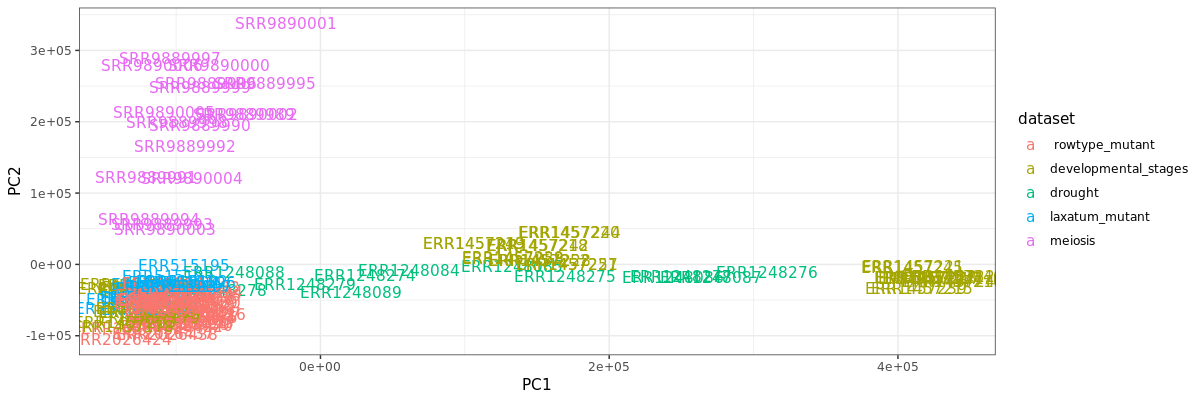

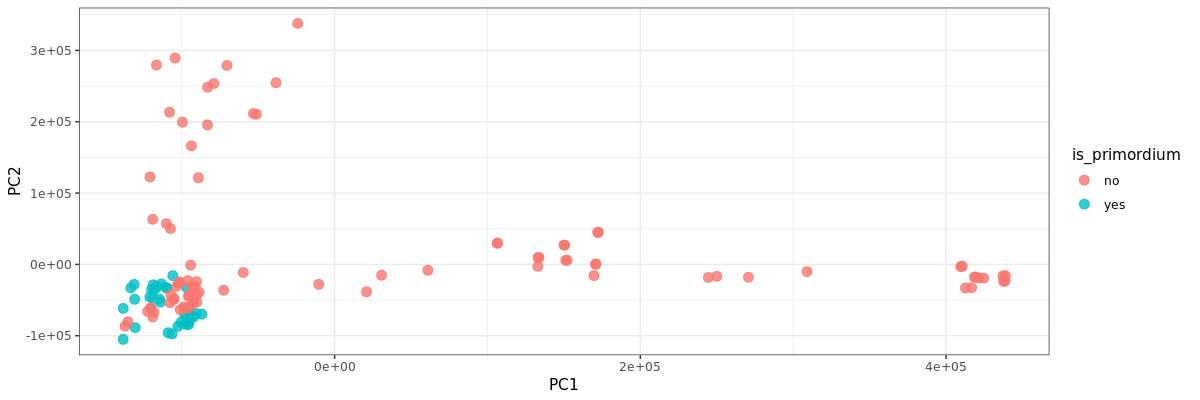

In [152]:
# check for pca
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 100)
plot_pca(so_flower5, color_by = 'dataset',text_labels = TRUE,units='scaled_reads_per_base')
plot_pca(so_flower5, color_by = 'is_primordium',text_labels = FALSE,units='scaled_reads_per_base')
# two main outliers from developmental stages dataset are rachis samples
# ERR1457171
# ERR1457170
# after excluding them the next new outlier ERR1457196 is a rachis sample from dataset as well

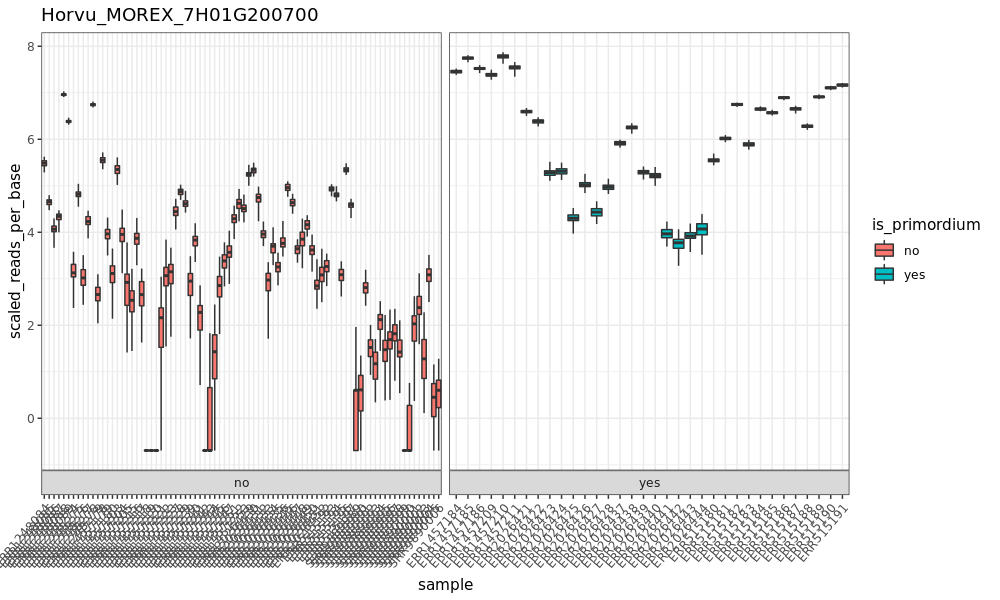

In [153]:
# check for bootstrapping
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
plot_bootstrap(so_flower5, 'Horvu_MOREX_7H01G200700', color_by = 'is_primordium',units='scaled_reads_per_base')

In [154]:
# create models
so_flower5 <- sleuth_fit(so_flower5, ~dataset + is_primordium, 'full')
so_flower5 <- sleuth_fit(so_flower5, ~dataset, 'reduced')

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [155]:
# perform DGE test
so_flower5 <- sleuth_lrt(so_flower5, 'reduced', 'full')

In [156]:
models(so_flower5)

[  full  ]
formula:  ~dataset + is_primordium 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis
 	is_primordiumyes
[  reduced  ]
formula:  ~dataset 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	datasetdevelopmental_stages
 	datasetdrought
 	datasetlaxatum_mutant
 	datasetmeiosis


In [157]:
table_flower5 <- sleuth_results(so_flower5, 'reduced:full', 'lrt', show_all = FALSE)
sig_flower5_1 <- filter(table_flower5, qval <= 0.1)
glimpse(sig_flower5_1)
sig_flower5_05 <- filter(table_flower5, qval <= 0.05)
glimpse(sig_flower5_05)
sig_flower5_01 <- filter(table_flower5, qval <= 0.01)
glimpse(sig_flower5_01)
# look at table and few of 0.05
head(sig_flower5_05, 5)

Rows: 16,532
Columns: 12
$ target_id       <chr> "Horvu_MOREX_4H01G522700", "Horvu_MOREX_5H01G494900",…
$ pval            <dbl> 3.285269e-35, 8.206469e-34, 2.081813e-31, 1.591798e-3…
$ qval            <dbl> 6.860298e-31, 8.568374e-30, 1.086811e-27, 1.086811e-2…
$ test_stat       <dbl> 153.30521, 146.91114, 135.91573, 136.44862, 134.55995…
$ rss             <dbl> 350.44606, 252.47567, 146.70877, 176.56917, 108.84774…
$ degrees_free    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ mean_obs        <dbl> 3.699630, 6.089140, 4.889356, 2.553926, 5.403491, 5.8…
$ var_obs         <dbl> 4.5731917, 6.5402875, 2.6429345, 4.1720205, 2.3906374…
$ tech_var        <dbl> 0.1015518234, 0.0186730038, 0.0417292915, 0.170539820…
$ sigma_sq        <dbl> 3.0556199, 2.2558826, 1.2799714, 1.4201734, 0.9698449…
$ smooth_sigma_sq <dbl> 0.45214268, 0.11880240, 0.22984511, 0.67727809, 0.170…
$ final_sigma_sq  <dbl> 3.0556199, 2.2558826, 1.2799714, 1.4201734, 0.9698449…
Rows: 14,613
Columns: 12
$ 

target_id               pval         qval         test_stat rss     
1 Horvu_MOREX_4H01G522700 3.285269e-35 6.860298e-31 153.3052  350.4461
2 Horvu_MOREX_5H01G494900 8.206469e-34 8.568374e-30 146.9111  252.4757
3 Horvu_MOREX_3H01G483800 2.081813e-31 1.086811e-27 135.9157  146.7088
4 Horvu_MOREX_4H01G068400 1.591798e-31 1.086811e-27 136.4486  176.5692
5 Horvu_MOREX_7H01G357200 4.120893e-31 1.721050e-27 134.5599  108.8477
  degrees_free mean_obs var_obs  tech_var   sigma_sq  smooth_sigma_sq
1 1            3.699630 4.573192 0.10155182 3.0556199 0.4521427      
2 1            6.089140 6.540287 0.01867300 2.2558826 0.1188024      
3 1            4.889356 2.642934 0.04172929 1.2799714 0.2298451      
4 1            2.553926 4.172021 0.17053982 1.4201734 0.6772781      
5 1            5.403491 2.390637 0.01076531 0.9698449 0.1707421      
  final_sigma_sq
1 3.0556199     
2 2.2558826     
3 1.2799714     
4 1.4201734     
5 0.9698449

In [158]:
# save 3 sets of DEGsin .csv
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/hordeum/")
write.table(sig_flower5_1, file = "deg_flower5_signif0_1.csv", sep = ",", col.names = TRUE)
write.table(sig_flower5_05, file = "deg_flower5_signif0_05.csv", sep = ",", col.names = TRUE)
write.table(sig_flower5_01, file = "deg_flower5_signif0_01.csv", sep = ",", col.names = TRUE)

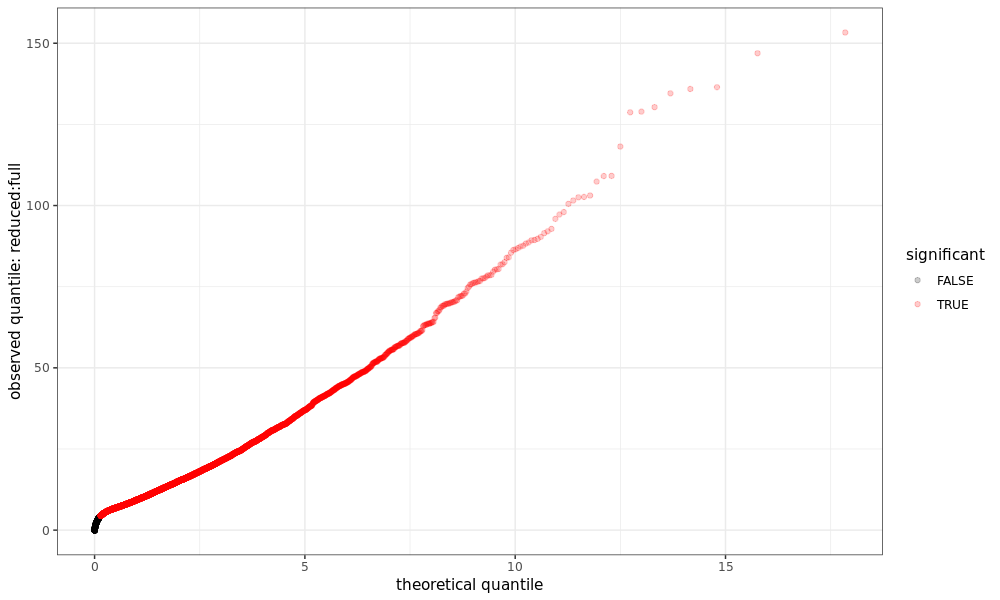

In [159]:
plot_qq(so_flower5, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

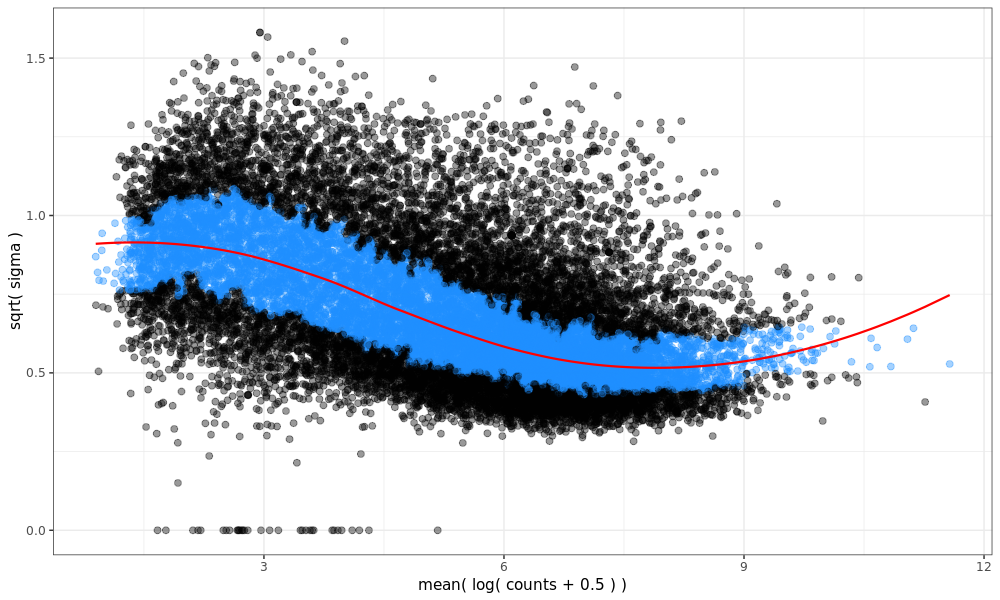

In [160]:
plot_mean_var(so_flower5,which_model="full")

In [176]:
sleuth_live_settings(test_type = "lrt")
sleuth_live(so_flower1, settings = sleuth_live_settings())
# in order to display: open new terminal tab and type: `ssh -L localhost:42427:localhost:42427 vanda.marosi@bee`
# number after localhost has to match the last number written in the output
# after this, copy and enter http site address 

$test_type
[1] "lrt"


Listening on http://127.0.0.1:42427


In [164]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/vanda.marosi/anaconda3/envs/r/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] shiny_1.3.2         pheatmap_1.0.12     vsn_3.54.0         
 [4] Biobase_2.46.0      BiocGenerics_0.32.0 RColorBrewer_1.1-2 
 [7] cowplot_1.0.0       forcats_0.5.0       stringr_1.4.0      
[10] dplyr_0.8.5         purrr_0.3.4         readr_1.3.1        
[13] tidyr_1.0.2       